## Содержание:
* [Стационарность](#stacionary)
* [Преобразование Бокса-Кокса](#boxcox)
* [Модели для предсказания значений временного ряда](#predict)
* [Метрики точности прогноза](#metrics)

Импортируем библиотеки

In [5]:
# Импортируем необходимые библиотеки

import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt

Рутина с датасетами

In [4]:
# аналогичным образом загружаем данные о пассажирах
graduses = pd.read_csv('data/Offset equipment temperature degrees Celsius observed every 10 minutes.csv')
# также устанавливаем индекс и сортируем
df = graduses.sort_index()

In [5]:
df.describe()

,Unnamed: 0,temperature
count,4325.000000,4325.000000
mean,2163.000000,29.225526
std,1248.664286,5.326126
min,1.000000,19.000000
25%,1082.000000,24.600000
50%,2163.000000,29.500000
75%,3244.000000,34.000000
max,4325.000000,39.500000


Отрисовываем временной ряд

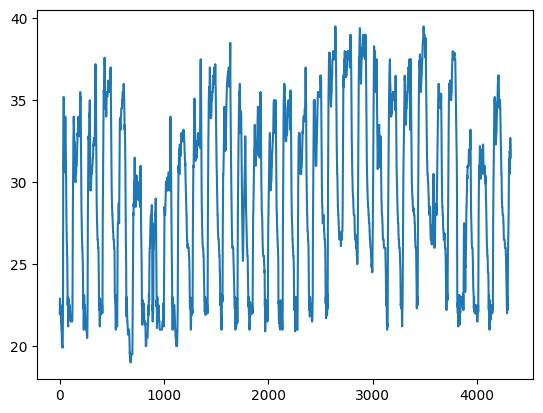

In [6]:
plt.plot(df["temperature"])

## Стационарный процесс  <a class="anchor" id="stacionary"></a>

Стационарный процесс - это случайный процесс, безусловное совместное распределение вероятностей которого не изменяется при сдвиге во времени. Следовательно, такие параметры, как среднее значение и дисперсия, также не меняются со временем, поэтому стационарные временные ряды легче прогнозировать.

Есть несколько способов установить, является ли временной ряд стационарным или нет, наиболее распространенными являются старая добрая визуализация, просмотр автокорреляции и выполнение статистических тестов.

Наиболее распространенным тестом является тест Дики-Фуллера (также называемый тест ADF), где нулевая гипотеза состоит в том, что временной ряд имеет единичный корень, другими словами, временной ряд не является стационарным.

Мы проверим, можно ли отвергнуть нулевую гипотезу, сравнив значение p с выбранным порогом (α), чтобы, если значение p меньше, мы могли отклонить нулевую гипотезу и предположить, что временной ряд с уверенностью является стационарным. уровень 1-α (технически мы просто не можем сказать, что это не так)

Временной ряд имеет единичный корень, или порядок интеграции один, если его первые разности образуют стационарный ряд. Это условие записывается как
$y_t\thicksim I(1)$ если ряд первых разностей $\triangle y_t=y_t-y_{t-1}$ является стационарным $\triangle y_t\thicksim I(0)$.

При помощи этого теста проверяют значение коэффициента $a$ в  авторегрессионном уравнении первого порядка AR(1)
$y_t=a\cdot y_{t-1}+\varepsilon_t,$
где $y_t$ — временной ряд, а $\varepsilon$— ошибка.

Если $a=1$, то процесс имеет единичный корень, в этом случае ряд $y_t$ не стационарен, является интегрированным временным рядом первого порядка $I(1)$. Если $|a|<1$, то ряд стационарный $I(0)$.


In [7]:
# импортируем функцию, описывающую тест Дики-Фуллера
from statsmodels.tsa.stattools import adfuller

In [8]:
# всю теорию, описанную выше, реализуем с помощью statsmodels для проверки
# временного ряда перевозок на стационарность

alpha = 0.05
name = "Температура"

# определяем временной ряд отдельной переменной
ts = df["temperature"]

print(f'Тест Дики-Фуллера ряда {name} :')
# определяем результат значения теста из библиотеки с учетом
dftest = adfuller(ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

if dfoutput["p-value"] < alpha:
    print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
else:
    print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

Тест Дики-Фуллера ряда Температура :


Test Statistic                -8.887923e+00
p-value                        1.265350e-14
#Lags Used                     1.300000e+01
Number of Observations Used    4.311000e+03
Critical Value (1%)           -3.431868e+00
Critical Value (5%)           -2.862211e+00
Critical Value (10%)          -2.567127e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


А теперь попробуем осуществить дифференцирование. Перед этим опять попробуем декомпозицию ряда.

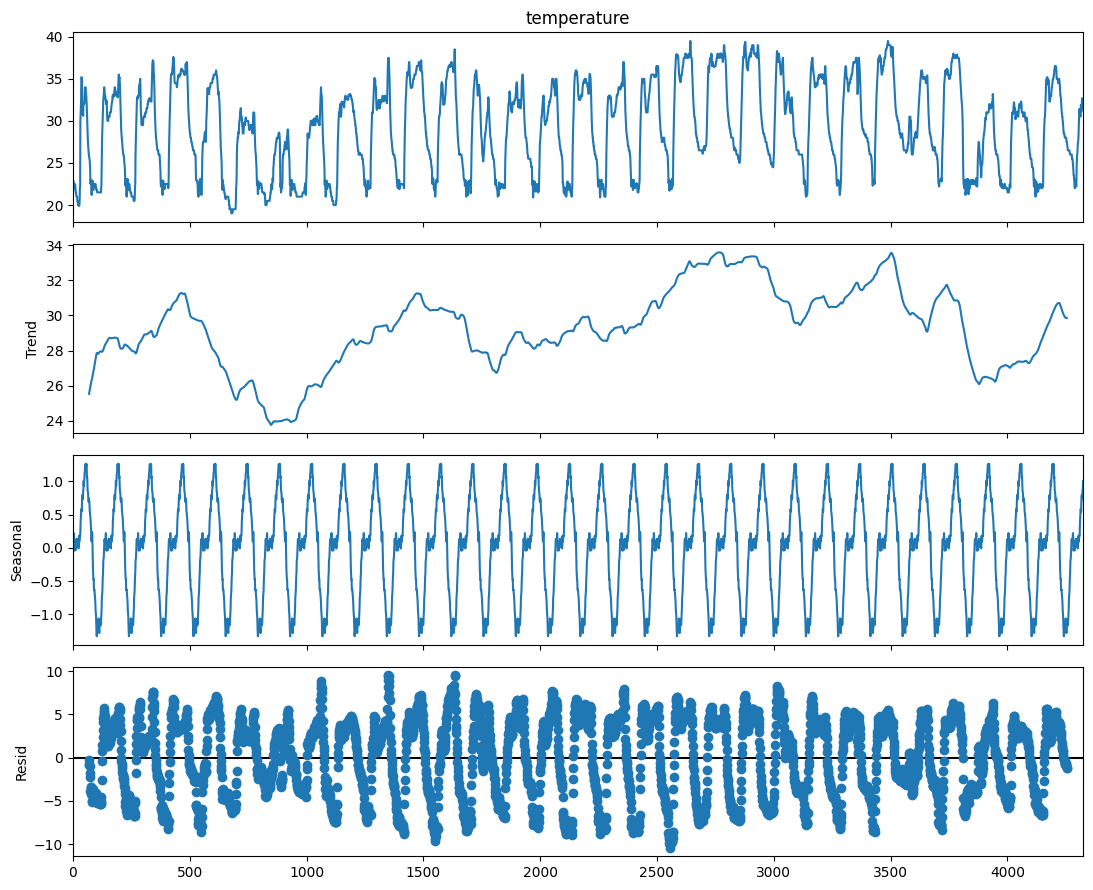

In [11]:
# импортируем функцию seasonal_decompose из statsmodels
# (то есть осуществляем декомпозицию сигнала/временного ряда)
from statsmodels.tsa.seasonal import seasonal_decompose

# задаем размер графика
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9


# применяем функцию к данным о перевозках
decompose = seasonal_decompose(graduses["temperature"], 
                               period=138)
decompose.plot()
plt.show()

Создадим два временных ряда на основе имеющегося, только без тренда и сезонности.

Удаляем тренд согласно формуле: $y' = y_t - y_{t-1}$;

Удаляем сезонность согласно формуле: $y' = y_t - y_{t-s}$;

In [12]:
nottrend = []
s = 138
notseason = []

# выборка без тренда
for i in range(1, len(df["temperature"])):
   nottrend.append(df["temperature"][i] - df["temperature"][i-1])

# выборка без сезонности
for i in range(s, len(df["temperature"])):
   notseason.append(df["temperature"][i] - df["temperature"][i-s])


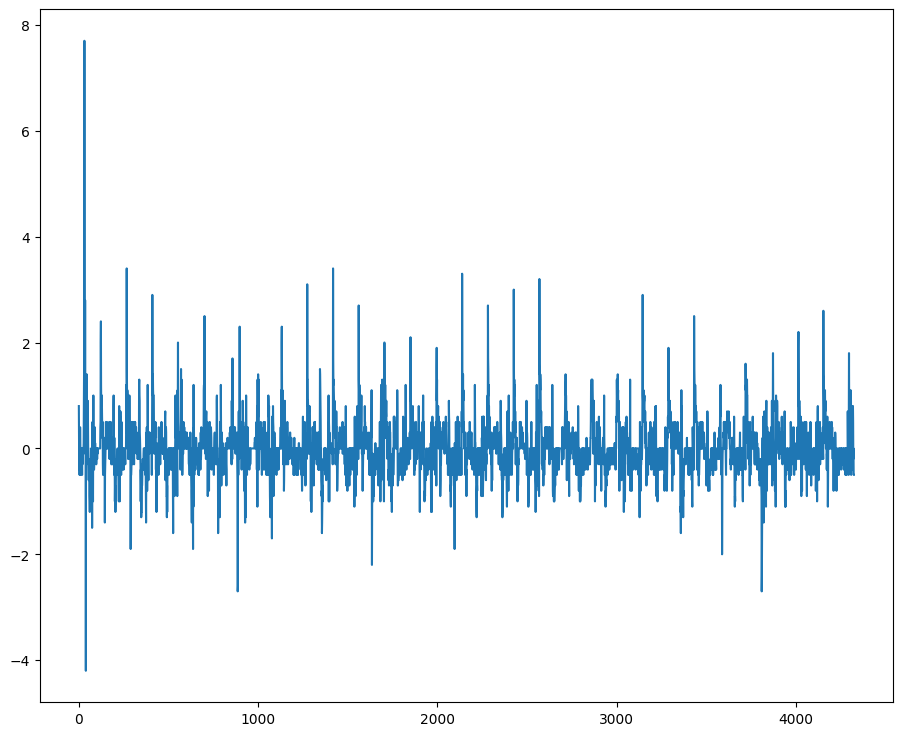

In [13]:
# отрисовываем временной ряд без тренда
plt.plot(nottrend)

Теперь проведем тест Дики-Фуллера на временном ряде без тренда

In [16]:
alpha = 0.05
name = "Температура без тренда"
 
ts = nottrend

print(f'Тест Дики-Фуллера ряда {name} :')
dftest = adfuller(ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

if dfoutput["p-value"] < alpha:
    print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
else:
    print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

Тест Дики-Фуллера ряда Температура без тренда :


Test Statistic                -1.655399e+01
p-value                        1.933722e-29
#Lags Used                     9.000000e+00
Number of Observations Used    4.314000e+03
Critical Value (1%)           -3.431867e+00
Critical Value (5%)           -2.862210e+00
Critical Value (10%)          -2.567127e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


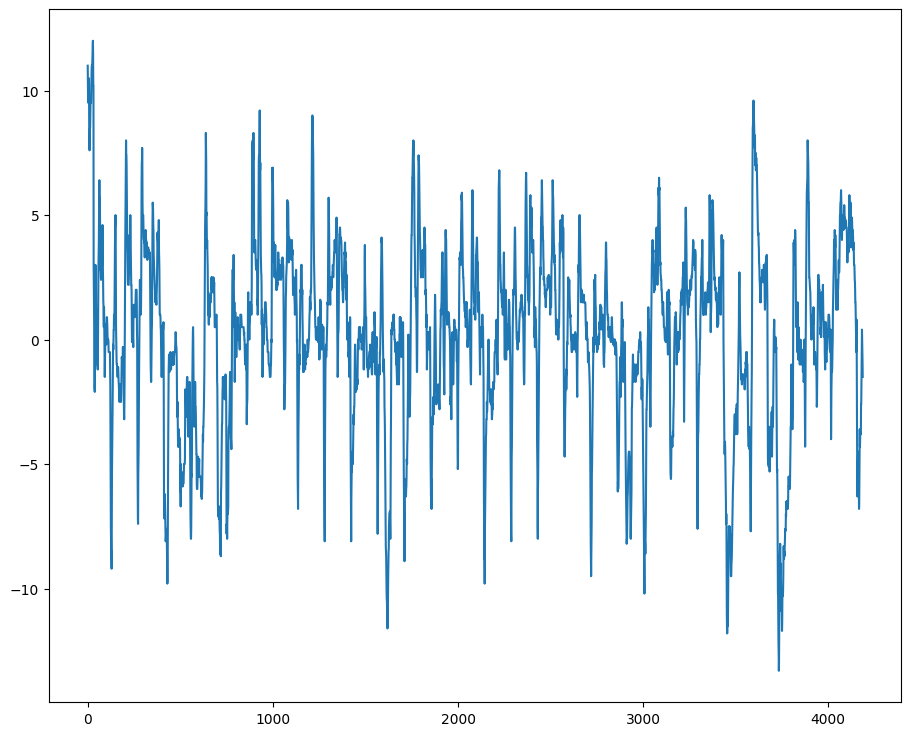

In [17]:
# отрисовываем временной ряд без сезонности
plt.plot(notseason)

Аналогичным образом проведем тест Дики-Фуллера на временном ряде без сезонности

In [18]:
alpha = 0.05
name = "Температура без сезона"
 
ts = notseason

print(f'Тест Дики-Фуллера ряда {name} :')
dftest = adfuller(ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

if dfoutput["p-value"] < alpha:
    print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
else:
    print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

Тест Дики-Фуллера ряда Температура без сезона :


Test Statistic                -7.929789e+00
p-value                        3.538359e-12
#Lags Used                     2.100000e+01
Number of Observations Used    4.165000e+03
Critical Value (1%)           -3.431921e+00
Critical Value (5%)           -2.862234e+00
Critical Value (10%)          -2.567140e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


## Преобразование Бокса-Кокса <a class="anchor" id="boxcox"></a>

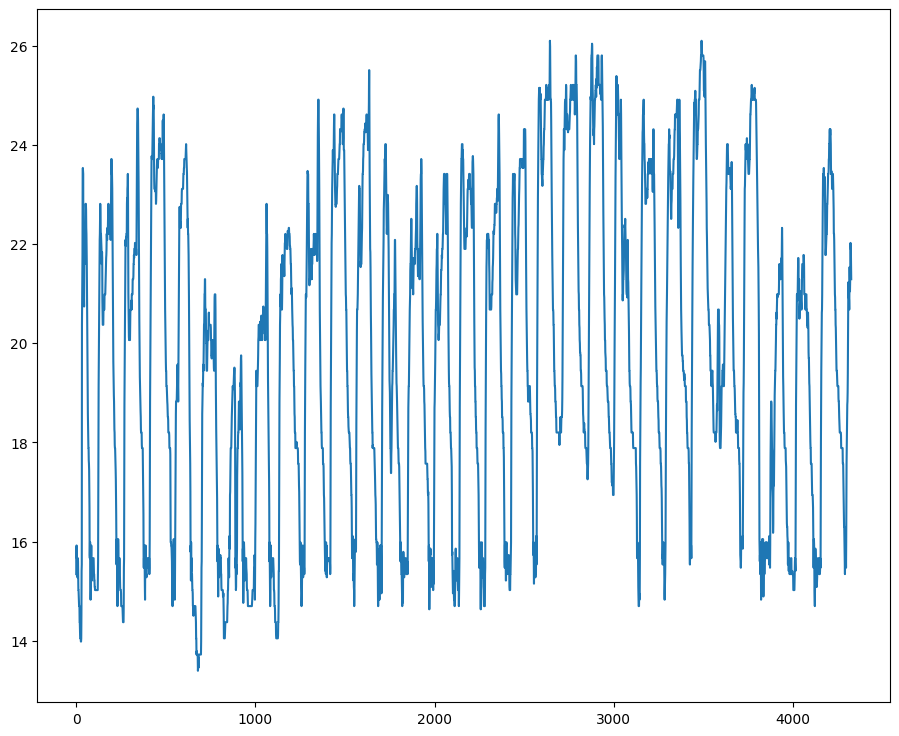

In [20]:
# Преобразование Бокса-Кокса
from scipy.stats import boxcox 

# вызываем функцию преобразования, которая выдает преобразованные данные и
# лучший параметр лямбда, который обеспечивает близость к нормальному
# распределению
transformed_data, best_lambda = boxcox(df["temperature"]) 

# а теперь посмотрим на преобразованные данные
plt.plot(transformed_data) 

Попробуем теперь из преобразованного временного ряда удалить тренд и
визуализировать его

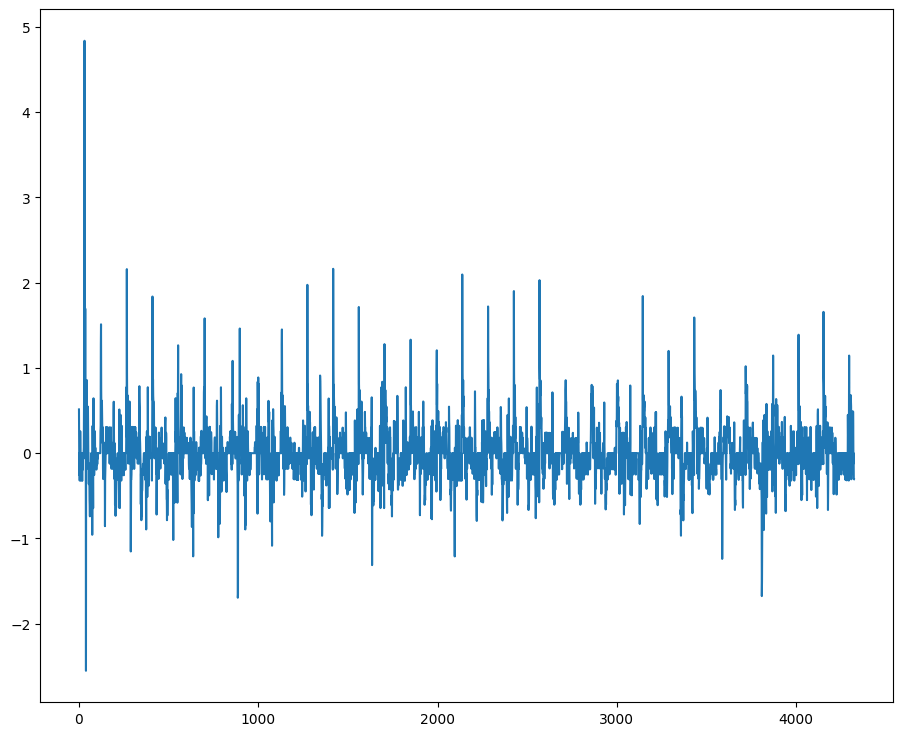

In [21]:
pnottrend = []

for i in range(1, len(transformed_data)):
   pnottrend.append(transformed_data[i] - transformed_data[i-1])


plt.plot(pnottrend) 

Удалив тренд из преобразованного Боксом-Коксом ряда, попробуем опять проверить его на стационарность. Что-то изменилось?

In [22]:
alpha = 0.05
name = "Температура после Кокса-Бокса"
 
ts = pnottrend

print(f'Тест Дики-Фуллера ряда {name} :')
dftest = adfuller(ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

if dfoutput["p-value"] < alpha:
    print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
else:
    print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

Тест Дики-Фуллера ряда Температура после Кокса-Бокса :


Test Statistic                -1.656012e+01
p-value                        1.910573e-29
#Lags Used                     9.000000e+00
Number of Observations Used    4.314000e+03
Critical Value (1%)           -3.431867e+00
Critical Value (5%)           -2.862210e+00
Critical Value (10%)          -2.567127e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


## Модели для предсказания значений временного ряда <a class="anchor" id="predict"></a>

Ладно, пора возвращаться к прогнозированию. Следаем прогноз с помощью AR модели, предварительно поделив выборки на обучающую, валидационную и тестовую.

In [8]:
df = pd.read_csv('data/Offset equipment temperature degrees Celsius observed every 10 minutes.csv', names=["n","x"], skiprows=1)


df['t'] = df.index.values

ln = len(df)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# делим выборки
train_df = df[df['t'] <= train_cutoff]
validate_df = df[(df['t'] > train_cutoff) & (df['t'] <= validate_cutoff)]
forecast_df = df[df['t'] > validate_cutoff]

Визуализируем поделенные выборки.

* Обучающая выборка - синим цветом
* Валидационная выборка - оранжевым цветом
* Предсказываемая выборка - зеленым цветом

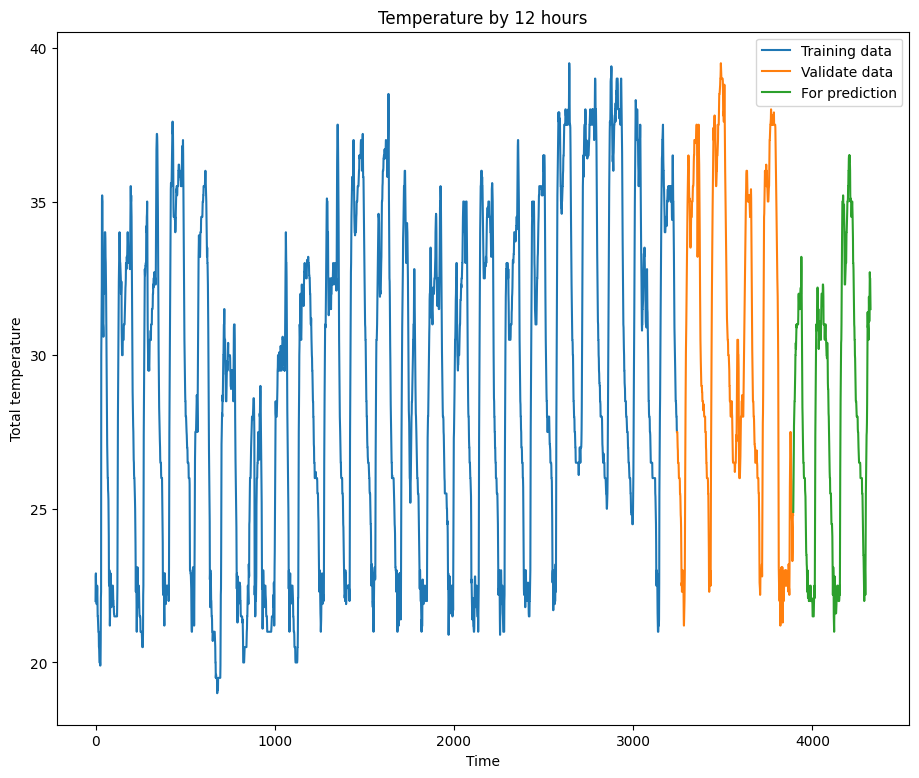

In [26]:
plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.legend()
plt.title('Temperature by 12 hours')
plt.ylabel('Total temperature')
plt.xlabel('Time')
plt.show()

In [13]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [28]:
# создаем объект модели на основе данных временного ряда с 3 лагами
mod = AutoReg(df.t, 3, old_names=False)
# обучаем
res = mod.fit()

# выводим сводку информации об авторегрессионной модели
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      t   No. Observations:                 4325
Model:                     AutoReg(3)   Log Likelihood               92059.970
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Thu, 12 Oct 2023   AIC                        -184109.940
Time:                        21:47:36   BIC                        -184078.083
Sample:                             3   HQIC                       -184098.692
                                 4325                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6667   1.38e-12   4.84e+11      0.000       0.667       0.667
t.L1           1.0000   1.38e-12   7.26e+11      0.000       1.000       1.000
t.L2           0.3333   5.52e-16   6.04e+14      0.0

In [29]:
# опять обучаем модель, но на этот раз указываем тип ковариационной оценки
res = mod.fit(cov_type="HC0")

# смотрим, что изменилось
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      t   No. Observations:                 4325
Model:                     AutoReg(3)   Log Likelihood               92059.970
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Thu, 12 Oct 2023   AIC                        -184109.940
Time:                        21:47:49   BIC                        -184078.083
Sample:                             3   HQIC                       -184098.692
                                 4325                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6667    8.7e-13   7.67e+11      0.000       0.667       0.667
t.L1           1.0000   8.69e-13   1.15e+12      0.000       1.000       1.000
t.L2           0.3333   6.06e-16    5.5e+14      0.0

Продолжаем экспериментировать

In [14]:
sel = ar_select_order(df.x, 13, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                 4325
Model:                     AutoReg(5)   Log Likelihood               -2302.224
Method:               Conditional MLE   S.D. of innovations              0.412
Date:                Thu, 12 Oct 2023   AIC                           4618.448
Time:                        22:02:41   BIC                           4663.045
Sample:                             5   HQIC                          4634.195
                                 4325                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2901      0.036      8.148      0.000       0.220       0.360
x.L1           1.4609      0.015     96.221      0.000       1.431       1.491
x.L2          -0.3806      0.027    -14.142      0.0

Смотрим, что он предсказал

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


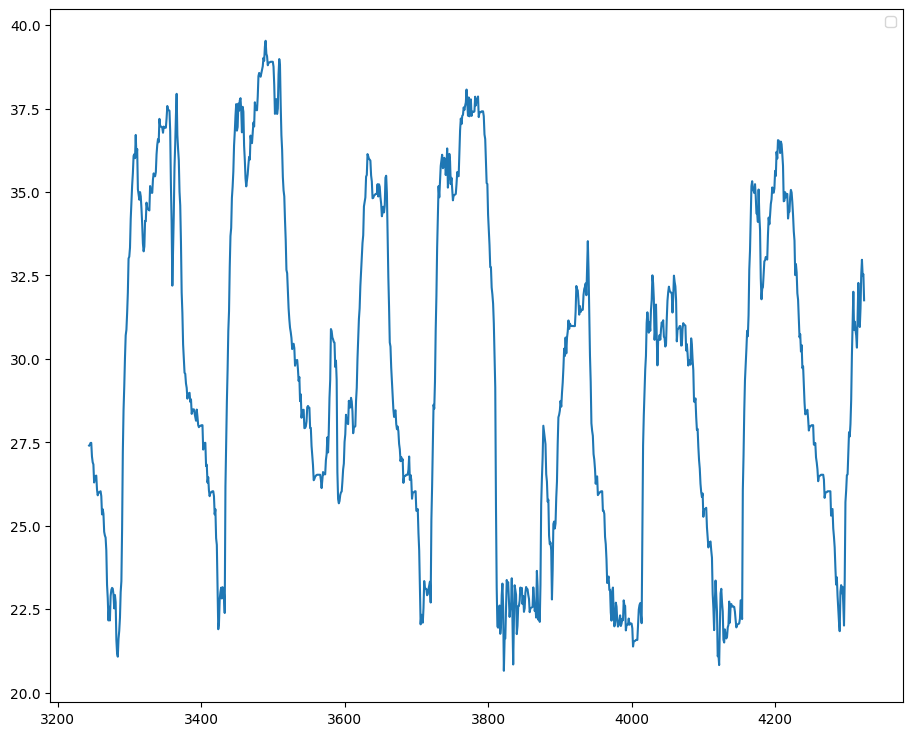

In [31]:
fig = res.plot_predict(train_cutoff)

Формируем предсказанные временные ряды

In [15]:
pred = res.predict(start=0, end=train_cutoff, dynamic=False)
v_pred = res.predict(start=train_cutoff+1, end=(validate_cutoff), dynamic=False)
f_pred = res.predict(start=validate_cutoff + 1, end=(forecast_df.t[len(df.t)-1]), dynamic=False)

Отрисовываем их

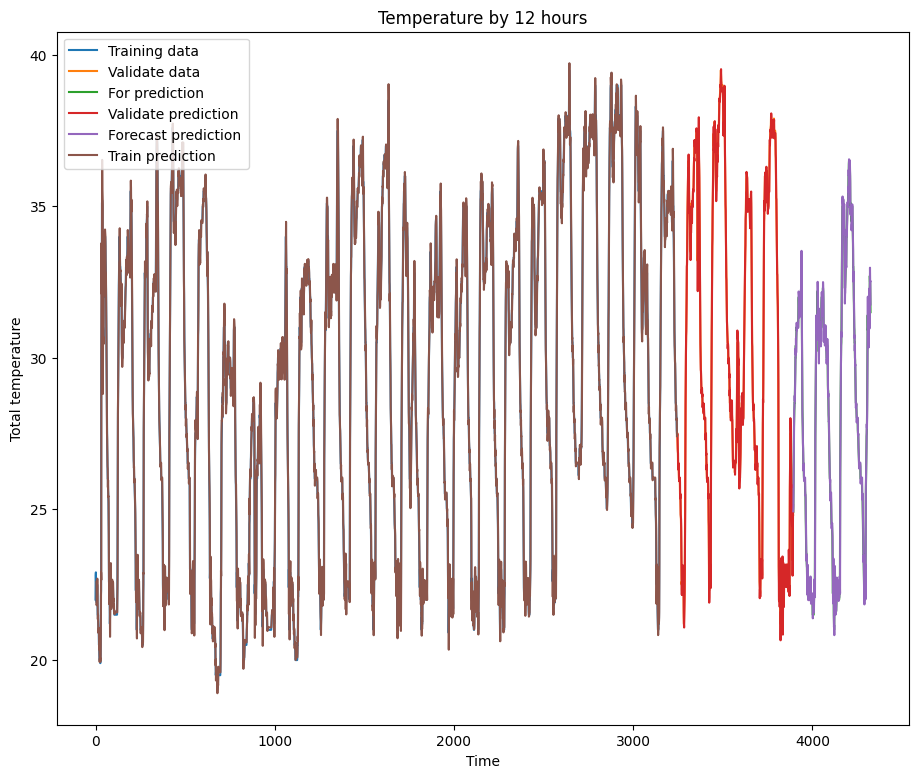

In [33]:
plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.plot(validate_df.t, v_pred, label='Validate prediction ')
plt.plot(forecast_df.t, f_pred, label='Forecast prediction')
plt.plot(train_df.t, pred, label='Train prediction')

plt.legend()
plt.title('Temperature by 12 hours')
plt.ylabel('Total temperature')
plt.xlabel('Time')
plt.show()

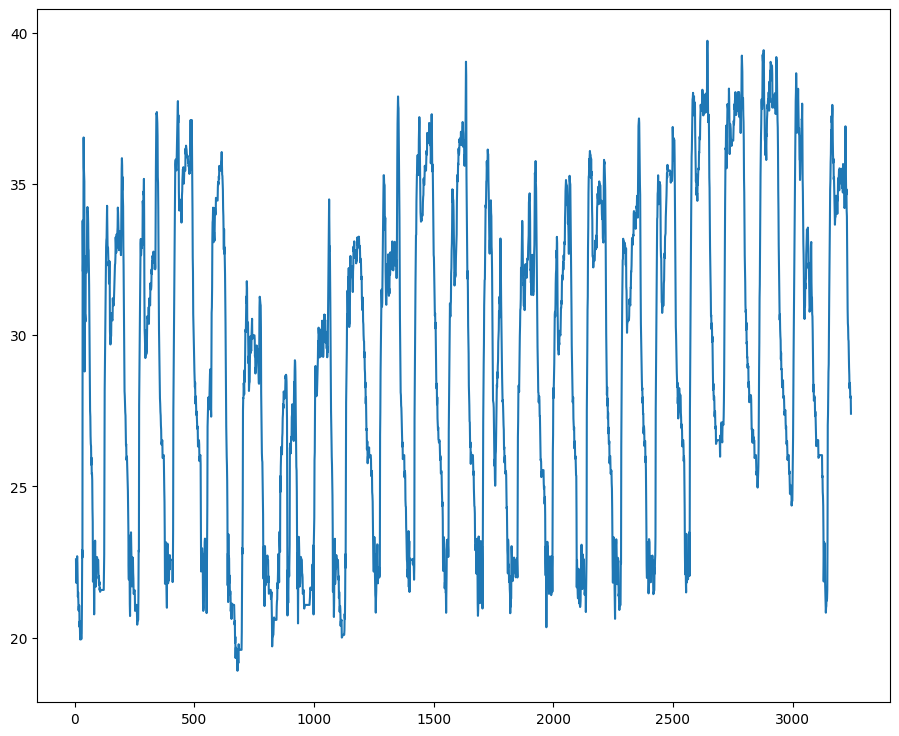

In [34]:
plt.plot(pred)

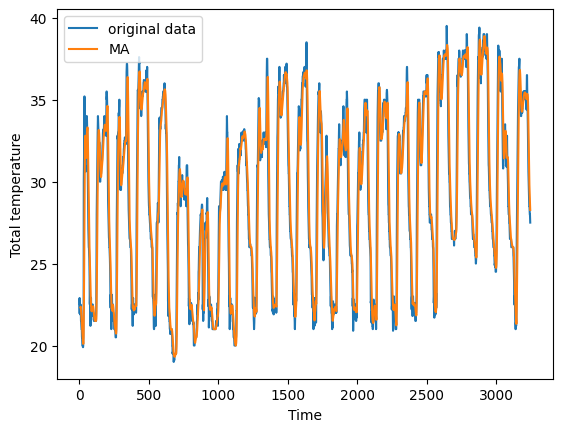

In [9]:
# MA

df['t'] = df.index.values

ln = len(df)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# делим выборки
train_df = df[df['t'] <= train_cutoff]
validate_df = df[(df['t'] > train_cutoff) & (df['t'] <= validate_cutoff)]
forecast_df = df[df['t'] > validate_cutoff]

plt.plot(train_df["t"], train_df["x"], label="original data")
plt.plot(train_df["t"], train_df["x"].rolling(10).mean(), label="MA")
plt.legend()
plt.ylabel('Total temperature')
plt.xlabel('Time')
plt.show()

## Метрики точности прогноза <a class="anchor" id="metrics"></a>

* R2- коэффициент детерминации     ​
* MSE (RMSE) – mean squared error – среднеквадратичная ошибка​
* MAE – mean absolute error – средняя абсолютная ошибка​
* MAPE – mean absolute percentage error – средняя абсолютная ошибка в %​
* SMAPE – symmetric mean absolute percentage error – симметричная средняя абсолютная ошибка в %

Определяем метрики точности прогноза из библиотеки sklearn. Попробуй определить последнюю оставшуюся метрику **SMAPE** самостоятельно.

In [2]:
pip install scikit-learn

                                              0.0/9.2 MB ? eta -:--:--
                                              0.0/9.2 MB ? eta -:--:--
                                              0.0/9.2 MB ? eta -:--:--
                                              0.0/9.2 MB ? eta -:--:--
                                              0.0/9.2 MB ? eta -:--:--
                                              0.0/9.2 MB ? eta -:--:--
                                              0.0/9.2 MB ? eta -:--:--
                                              0.0/9.2 MB ? eta -:--:--
                                              0.1/9.2 MB 209.0 kB/s eta 0:00:44
                                              0.1/9.2 MB 209.0 kB/s eta 0:00:44
                                              0.1/9.2 MB 209.0 kB/s eta 0:00:44
                                              0.1/9.2 MB 209.0 kB/s eta 0:00:44
                                              0.1/9.2 MB 154.3 kB/s eta 0:01:00
                                


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

Вычислим значения ошибок модели AR, опираясь на предсказанные ею значения forecast.

In [17]:
print("RMSE:", np.sqrt(mean_squared_error(forecast_df.x, f_pred)))
print("MAPE:", mean_absolute_percentage_error(forecast_df.x, f_pred))
print("MAE:", mean_absolute_error(forecast_df.x, f_pred))
print("R2: ", r2_score(forecast_df.x, f_pred))
print("SMAPE", 2.0 * np.mean(np.abs(f_pred - forecast_df.x) / (np.abs(f_pred) + np.abs(forecast_df.x))) * 100)

RMSE: 0.3542018765961587
MAPE: 0.0087840701594904
MAE: 0.24244149897437206
R2:  0.9933771265857327
SMAPE 0.8804698541715721
